### Acknowledgement
Name: Zuha Aqib     
ERP ID: 26106    
Section: 10am Miss Solat     
Date: (written on) 18-Feb-25     

code has been taken from Miss Solat's code files and written by Zuha themselves. 

In [181]:
from datetime import datetime
print("Last time code executed:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Last time code executed: 2025-02-23 15:08:16


In [182]:
erp = 26106 
# will be referenced later on in the code when we use it for random_state
erp

26106

# Imports
here we import all the necessary libraries and modules

In [183]:
# to load the dataset
import warnings
warnings.filterwarnings('ignore')

# to handle the data and perform numerical operations on it
import pandas as pd
import numpy as np

# to do natural language processing
import nltk

# preprocessing: to clean the data
import re

# preprocessing: words tokenization
from nltk.tokenize import word_tokenize

# preprocessing: stemmming and lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# vectorization: BOW
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# vectorization: LSA
from sklearn.decomposition import TruncatedSVD

# clustering: k means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to plot the graph
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data] Error downloading 'punkt' from
[nltk_data]     <https://raw.githubusercontent.com/nltk/nltk_data/gh-
[nltk_data]     pages/packages/tokenizers/punkt.zip>:   <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Time Displayer
this code is a function that we will call at multiple instances of the code to see how long it took to run the code to see when it ran

In [184]:
# Function to get current date and time as a string
def get_current_datetime():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Load the Dataset
Here we load the dataset from a csv file and then save it into a variable

In [185]:
df = pd.read_csv("dataset/news_Feb_14.csv")
df = df.iloc[:, 0]  # Select only the headline column
documents = df.tolist()  # Convert to list
documents

['ECC endorses purchase of $582mn capital shares in BRICS’s New Development Bank',
 'Netanyahu’s statement to establish Palestinian state in Saudi Arabia irresponsible, provocative: FO',
 'India, US agree to resolve trade and tariff rows after Trump-Modi talks',
 'Aurangzeb discusses Pakistan’s structural reforms with IFC chief',
 'HBL, S&P Global launch Pakistan’s first manufacturing PMI',
 'KSE-100 closes 479 points lower as late-session selling erases intra-day gains',
 'PPL executes agreements for Sui Gas Field operations',
 'Hubco Green, PSO collaborate to setup EV charging infrastructure across Pakistan',
 'Rupee records marginal improvement against US dollar',
 'At least 9 dead, 7 injured in Balochistan’s Harnai blast',
 'Gold adds to record rally, reaches Rs306,200 per tola in Pakistan',
 'IMF’s 2024 Article IV report, and debate on inflation—I',
 'Pakistan CPI 2024 – deep-rooted corruption persists',
 '‘Like a wormhole’: Musk promises ‘Dubai Loop’ tunnel network',
 'Reforming 

In [186]:
original_headlines = documents.copy()  # Keep original headlines before preprocessing

# Preprocessing
here we perform the preprocessing of data like:
- lowercase text
- stopword removal
- stemming or lemmatization
- n-grams

## Lowercase Conversion
here we convert our text to lowercase to have accurate DTM/TDM

In [187]:
documents = [document.lower() for document in documents]

print("Finished executing at:", get_current_datetime())
documents

Finished executing at: 2025-02-23 15:08:28


['ecc endorses purchase of $582mn capital shares in brics’s new development bank',
 'netanyahu’s statement to establish palestinian state in saudi arabia irresponsible, provocative: fo',
 'india, us agree to resolve trade and tariff rows after trump-modi talks',
 'aurangzeb discusses pakistan’s structural reforms with ifc chief',
 'hbl, s&p global launch pakistan’s first manufacturing pmi',
 'kse-100 closes 479 points lower as late-session selling erases intra-day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistan’s harnai blast',
 'gold adds to record rally, reaches rs306,200 per tola in pakistan',
 'imf’s 2024 article iv report, and debate on inflation—i',
 'pakistan cpi 2024 – deep-rooted corruption persists',
 '‘like a wormhole’: musk promises ‘dubai loop’ tunnel network',
 'reforming 

## Data Cleaning
here we clean the data

In [188]:
import re
import unicodedata

def clean_text(text):
    text = text.encode('ascii', 'ignore').decode()  # Remove non-ASCII characters
    text = unicodedata.normalize("NFKD", text)  # Normalize Unicode text
    
    # Separate numbers attached to words
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)  # number-word
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)  # word-number
    
    text = text.replace("-", " ") # replace hyphens with spaces to tokenize the numbers and words
    text = re.sub(r'[^\w\s,]', '', text)  # Remove everything except words, numbers, and commas
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra spaces
    
    return text

In [189]:
documents = [clean_text(text) for text in documents]
documents

['ecc endorses purchase of 582 mn capital shares in bricss new development bank',
 'netanyahus statement to establish palestinian state in saudi arabia irresponsible, provocative fo',
 'india, us agree to resolve trade and tariff rows after trump modi talks',
 'aurangzeb discusses pakistans structural reforms with ifc chief',
 'hbl, sp global launch pakistans first manufacturing pmi',
 'kse 100 closes 479 points lower as late session selling erases intra day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistans harnai blast',
 'gold adds to record rally, reaches rs 306,200 per tola in pakistan',
 'imfs 2024 article iv report, and debate on inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like a wormhole musk promises dubai loop tunnel network',
 'reforming pension funds i

## Stop Words Removal
here we remove stop words. but we initialize stop words in count vectorizer. we have two other options of:
- either declaring all possible stop words and then iteratively checking each word in the document if its a stop word and then adding the non-stop words. However this is not a good practice. 
- pulling stop words from ```ntlk``` library:
```
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
documents_no_stopwords = [" ".join([word for word in doc.split() if word not in stop_words]) 
```
however after running this code it didnt not remove stop words thus i removed it

In [190]:
stop_word = False
stop_word_language = 'english'

stop_word

False

## Reduction
here we change words to a smaller common form instead of the 's. We do this using two ways:
- stemming
- lemmatization

### Stemming
this reduces words to their singular form however it is not said to be very good. we cannot say this surely as we have not rigourously tested it yet. 

In [191]:
# stemmer = PorterStemmer()
# documents = [" ".join([stemmer.stem(word) for word in doc.split()]) for doc in documents]

# print("Finished executing at:", get_current_datetime())
# documents

### Lemmatization
this also reduces words to their singular form and is said to be better as it only reduces to words in the dictionary. but again we cannot say this surely as we have not tested it yet. 

In [192]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_doc(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [193]:
documents = [lemmatize_doc(doc) for doc in documents]
documents

['ecc endorses purchase of 582 mn capital share in bricss new development bank',
 'netanyahus statement to establish palestinian state in saudi arabia irresponsible , provocative fo',
 'india , u agree to resolve trade and tariff row after trump modi talk',
 'aurangzeb discusses pakistan structural reform with ifc chief',
 'hbl , sp global launch pakistan first manufacturing pmi',
 'kse 100 close 479 point lower a late session selling erases intra day gain',
 'ppl executes agreement for sui gas field operation',
 'hubco green , pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee record marginal improvement against u dollar',
 'at least 9 dead , 7 injured in balochistans harnai blast',
 'gold add to record rally , reach r 306,200 per tola in pakistan',
 'imf 2024 article iv report , and debate on inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like a wormhole musk promise dubai loop tunnel network',
 'reforming pension fund in pakistan a su

## N-Grams
here we decide how we want the words to be tokenized, either they are
- unigram: singular
- bigram: pairs (doubular)

In [194]:
n_gram_range = (1, 1) # unigram
# n_gram_range = (2, 2) # bigram

n_gram_range

(1, 1)

# Vectorization
here we convert the text to numerical format for the model to understand it. we have four ways to do it:
- CountVectorizer using term-presence
- CountVextorizer using term-frequency
- TfidfVectorizer using term-frequency-inverse-document-frequency
- LSA using different 'n'

in this code we are exploring the third method

## TF-IDF
here we construct a DTM (document to term matrix) using term-frequency inverse-data-frequency

In [195]:
if stop_word is True:
    vectorizer = TfidfVectorizer(stop_words=stop_word_language, ngram_range=n_gram_range)
    documents = vectorizer.fit_transform(documents)
    print('Stop words removed')
else:
    vectorizer = TfidfVectorizer(ngram_range=n_gram_range)
    documents = vectorizer.fit_transform(documents)
    print('All words kept')

print("Finished executing at:", get_current_datetime())
documents.toarray()[:5]

All words kept
Finished executing at: 2025-02-23 15:08:29


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [196]:
# Get feature names (words) from CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Convert sparse matrix to DataFrame
df = pd.DataFrame(documents.toarray(), columns=feature_names)

df

000       092   10  100  106   11  114  117  120  121       129   13  \
0    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
1    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
2    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
3    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
4    0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
..   ...       ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...   
448  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
449  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
450  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
451  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
452  0.0  0.327214  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.327214  0.0   

     132   14   16   17  174  186   19  1975   20  200  2008  2024  2025  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
..   ...  ...  ...  ...  ...  ...  ...   ...  ...  ...   ...   ...   ...   
448  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
449  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
450  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
451  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   
452  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   0.0   0.0   0.0   

     2030  2034   24  243   25  250  252   26   27   28  285  306  312   35  \
0     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..    ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
448   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
449   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
450   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
451   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
452   0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

     360  361   38  394   42   43  460  479   50  500   55       582   69  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.319318  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...   
448  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
449  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
450  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
451  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   
452  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0   

      75   76   80   84   85   87   88   96   97  aap  about  above  abroad  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0     0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0    0.0     0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

In [197]:
# pd.set_option('display.max_columns', None)  # Show all columns
# print(df.head(1))  # Show first X rows

In [198]:
# Find (column, row) indices where frequency != 0
indices = np.argwhere(df.values != 0)

# Convert indices to a list of (word, row) pairs
word_occurrences = [(df.columns[col], row) for row, col in indices]

# Display the result
print(word_occurrences[:5])

[('582', 0), ('bank', 0), ('bricss', 0), ('capital', 0), ('development', 0)]


In [199]:
print(df.columns.tolist())  # Converts Index object to list

['000', '092', '10', '100', '106', '11', '114', '117', '120', '121', '129', '13', '132', '14', '16', '17', '174', '186', '19', '1975', '20', '200', '2008', '2024', '2025', '2030', '2034', '24', '243', '25', '250', '252', '26', '27', '28', '285', '306', '312', '35', '360', '361', '38', '394', '42', '43', '460', '479', '50', '500', '55', '582', '69', '75', '76', '80', '84', '85', '87', '88', '96', '97', 'aap', 'about', 'above', 'abroad', 'abuse', 'ac', 'access', 'accident', 'account', 'accuses', 'across', 'act', 'acting', 'action', 'actor', 'ada', 'adani', 'add', 'address', 'admin', 'administers', 'administration', 'admits', 'admitted', 'adoption', 'advance', 'advanced', 'advice', 'advocate', 'affordable', 'afghan', 'afghanistan', 'africa', 'african', 'afridi', 'after', 'afzal', 'aga', 'again', 'against', 'agency', 'agenda', 'ago', 'agree', 'agreement', 'agri', 'agricultural', 'agriculture', 'ahead', 'ahmed', 'ahmer', 'ai', 'aim', 'air', 'aircraft', 'ajk', 'akbar', 'akbars', 'akram', 'al

# K Means Clustering
here we cluster the documents into similar categories using k means clustering algorithm. we will be testing the algorithm for three values of k: 5, 9 and 13

In [200]:
def display_k_means(k, data):
    print(f"Displaying {k} start time:", get_current_datetime())
    
    svd = TruncatedSVD(n_components=2, random_state=42)
    data = svd.fit_transform(data)
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    # Convert to DataFrame for visualization
    df_viz = pd.DataFrame({'X': data[:, 0], 'Y': data[:, 1], 'Cluster': labels})

    # Scatter plot of clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_viz, x='X', y='Y', hue='Cluster', palette='tab10', s=100, edgecolor='black')
    plt.title("K-Means Clustering Visualization (2D Projection)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.show()
    
    print("Finished displaying at:", get_current_datetime(), "\n")

In [201]:
def run_k_means(k, data):
    print(f"Executing {k} start time:", get_current_datetime())
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    wss = kmeans.inertia_  # Within-Cluster Sum of Squares
    silhouette_avg = silhouette_score(data, labels)  # Silhouette Score
    
    print(f"K={k}: Silhouette Score and WSS={silhouette_avg:.4f}\t{wss:.4f}")
    
    values = [[silhouette_avg, wss]]
    # Create DataFrame and copy to clipboard
    df = pd.DataFrame(values)
    df.to_clipboard(index=False, header=False)
    print("copied to clipboard")
    
    # Create a DataFrame to store headlines with their assigned clusters
    df_clusters = pd.DataFrame({'Headline': original_headlines, 'Cluster': labels})

    # Display sample headlines per cluster
    for cluster in range(k):
        print(f"\nCluster {cluster}:")
        sample_headlines = df_clusters[df_clusters["Cluster"] == cluster].sample(n=min(5, len(df_clusters[df_clusters["Cluster"] == cluster])), random_state=erp)
        for idx, row in sample_headlines.iterrows():
            print(f"- {row['Headline']}")
    
    display_k_means(k, data)
    
    print("Finished executing at:", get_current_datetime(), "\n")

Executing 5 start time: 2025-02-23 15:08:30
K=5: Silhouette Score and WSS=0.0034	438.6803
copied to clipboard

Cluster 0:
- IK urges army chief to revisit policies in ‘best national interest’
- First Lady of Turkiye visits Maarif International School in Islamabad
- Second death anniversary of Zia Mohyeddin observed
- Law ministry notifies appointments of six SC judges, four high court chief justices
- Punjab PA session begins amid highly tense atmosphere: Performance of ‘Specialised Healthcare Dept’ comes under severe criticism

Cluster 1:
- Ahmer honored for contributions to squash at K2 Squash Gold Event
- ICC announces prize money breakdown for Champions Trophy
- JazzCash, Mobilink Bank named finalists for prestigious GLOMO Awards 2025
- Bots dupe the lonely looking for love and access financial accounts
- UEFA Champions League playoffs: Bayern, Benfica in ideal position

Cluster 2:
- Pakistan, Turkey set sights on $5b trade
- Pakistan,Turkiye commit to strengthen cooperation, targe

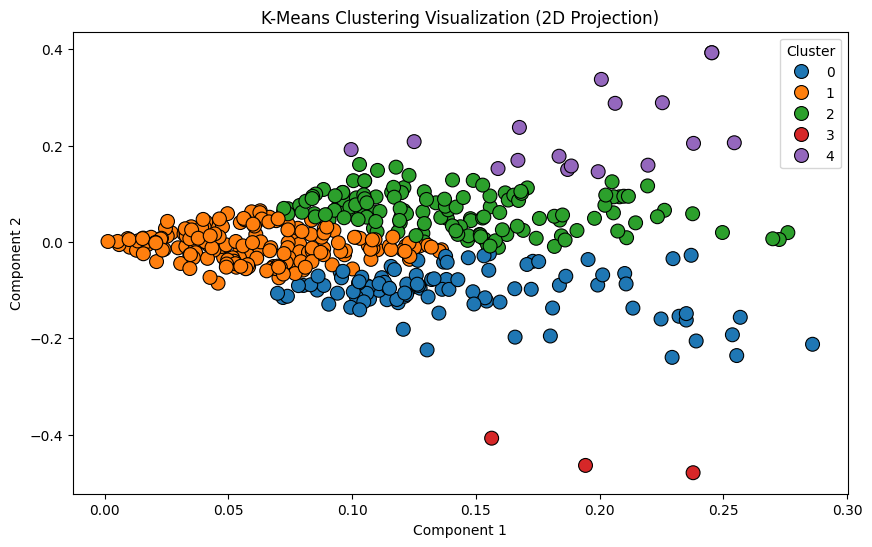

Finished displaying at: 2025-02-23 15:08:30 

Finished executing at: 2025-02-23 15:08:30 



In [202]:
run_k_means(5, documents)

Executing 9 start time: 2025-02-23 15:08:30
K=9: Silhouette Score and WSS=0.0033	432.2874
copied to clipboard

Cluster 0:
- Punjab PA session begins amid highly tense atmosphere: Performance of ‘Specialised Healthcare Dept’ comes under severe criticism
- Acting NASA chief says DOGE to review space agency spending as hundreds take buyout
- Law ministry notifies appointments of six SC judges, four high court chief justices
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC
- Kuwait hosts high-level forum to discuss International Islamic Court of Justice

Cluster 1:
- Karachi administration revises timings for movement of heavy vehicles
- ‘England can be dangerous in Champions Trophy despite India loss’, says Butler
- I want to become a UFC World Champion, Bano Butt on her dreams and breaking barriers
- Britain announces new sanctions against Putin allies
- Druski roasted by NBA fans for bold 2025 All-Star game stat predictions and lack of defense

Cluster 2:
- Oscar winner

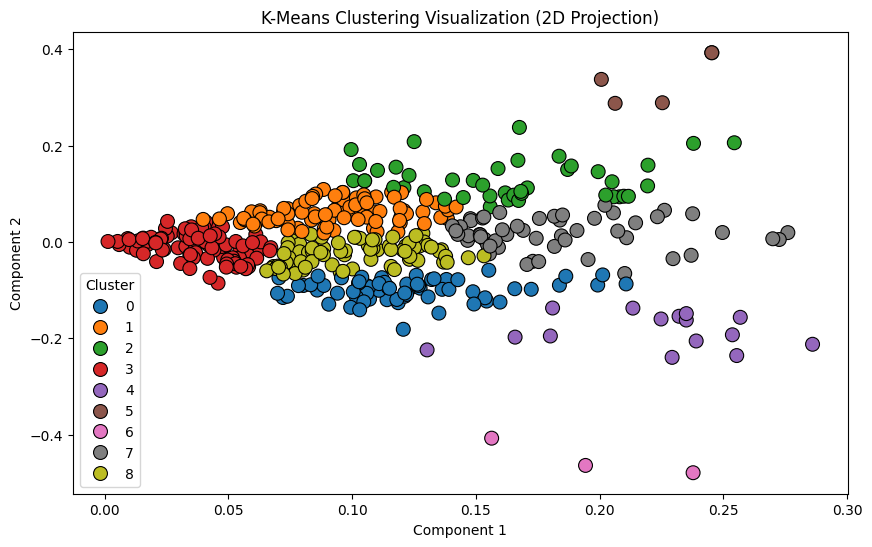

Finished displaying at: 2025-02-23 15:08:30 

Finished executing at: 2025-02-23 15:08:30 



In [203]:
run_k_means(9, documents)

Executing 13 start time: 2025-02-23 15:08:30
K=13: Silhouette Score and WSS=0.0044	426.3203
copied to clipboard

Cluster 0:
- JUI-F chief stands with journalists against PECA law
- Police charge couple with murder of child maid
- IK urges army chief to revisit policies in ‘best national interest’
- ECC approves transfer of shares of DISCOs in President of Pakistan’s name
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC

Cluster 1:
- Karachi administration revises timings for movement of heavy vehicles
- Pakistan Air Force fighter Jets to kick off ICC Champions Trophy 2025 in Style
- PAF’s JF-17 to perform at Champions Trophy opening ceremony in Karachi
- Mohsin Naqvi announces three-day spring festival in Islamabad
- Local bodies members flexing muscles for another protest in Peshawar

Cluster 2:
- UK, US agree Zelenskiy must be part of Ukraine peace talks, UK foreign minister says
- Economic indicators showing positive trends, says Khurram Schehzad
- Sean Strickland r

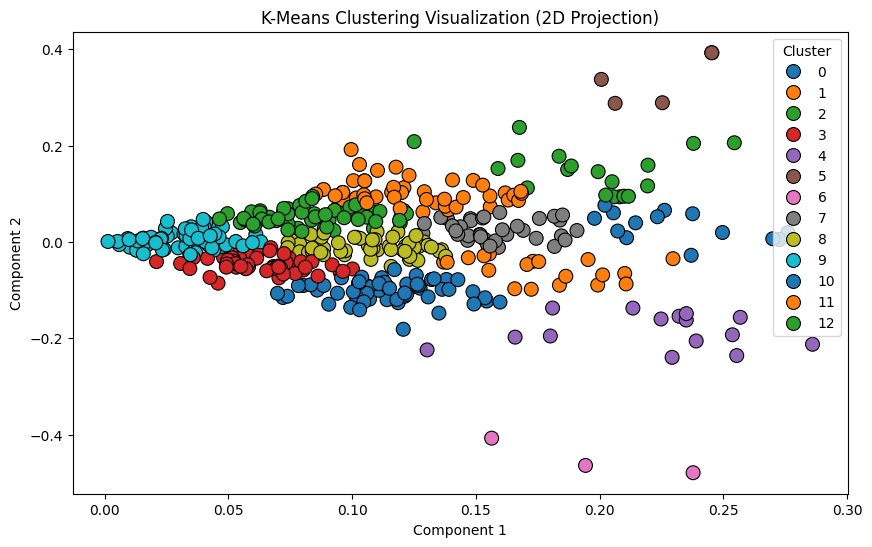

Finished displaying at: 2025-02-23 15:08:30 

Finished executing at: 2025-02-23 15:08:30 



In [204]:
run_k_means(13, documents)